# <center>The Battle of Neighborhoods</center>

## Introduction

People are traveling around world to different cities. We are so familiar with our own hometown, we know where to go if we want to go shopping, which area is best for night life and so on. Once we go to a different city, we are able to find a particular store to shop, or restaurants for dinner using various mapping tools without difficulty. However it is not easy to search a neighborhoods that fit our needs. For example, Person A might like a place with lots of restaurants but less bar, more education institutes. Person B might like place with lots of recreations but less restaurants. How could we utilized data and machine learning to help us make decision and find appropriate neighborhoods? This is the problem I would like to address in this capstone project. In this project, I am going to use New York City and Toronto as an example, and use Foursquare location data and cluster machine learning to group the location to different group by their venues information. And then try to find the most relevant neighborhoods between the two cities given the preference you provided. 

## Data

**Import Libary**

In [1]:
from bs4 import BeautifulSoup
import requests
import numpy as np
import pandas as pd
import json 
from geopy import geocoders
from geopy.geocoders import Nominatim 
import requests # library to handle requests
from pandas.io.json import json_normalize 
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium # map rendering library
print('Libraries imported.')

Libraries imported.


**Get neighborhood data for New York using json**

In [2]:
# New York Data
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('New York Data downloaded!')
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
neighborhoods_ny_data = newyork_data['features']
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods_ny = pd.DataFrame(columns=column_names)

for data in neighborhoods_ny_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods_ny = neighborhoods_ny.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
neighborhoods_ny.head() 

New York Data downloaded!


,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [4]:
print('New York has {} boroughs and {} neighborhoods.'.format(len(neighborhoods_ny['Borough'].unique()),neighborhoods_ny.shape[0]))

New York has 5 boroughs and 306 neighborhoods.


**Us BeautifulSoup to web scrap the Toronto neighborhood data**

In [5]:
#Toronto Data
#Use BeautifulSoup retrive neibourghood data from the web
source = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup = BeautifulSoup(source, 'lxml')
table = soup.find('table')

In [7]:
neighborhoods_to=[]
head = [items.text.strip() for items in table.find_all('th')]

for rows in table.find_all('tr'):
    cols = [items.text.strip() for items in rows.find_all('td')]
    neighborhoods_to.append(cols)
    
neighborhoods_to[0]=head
# create the dataframe with retrived data and clean data
neighborhoods_to=pd.DataFrame(neighborhoods_to[1:], columns=neighborhoods_to[0])

# remove rows with a borough that is Not assigned.
neighborhoods_to=neighborhoods_to[neighborhoods_to['Borough']!='Not assigned']

# Combine rows with same Postcode and Borough
neighborhoods_to = neighborhoods_to.groupby(['Postcode','Borough'])['Neighbourhood'].apply(lambda x: ','.join(x)).reset_index()

# If a cell has a borough but a Not assigned neighborhood, replace with the borough
neighborhoods_to['Neighbourhood'] = np.where(neighborhoods_to['Neighbourhood'] == 'Not assigned', 
                                             neighborhoods_to['Borough'], 
                                             neighborhoods_to['Neighbourhood'])

neighborhoods_to.head()

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge,Malvern"
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union"
2,M1E,Scarborough,"Guildwood,Morningside,West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [8]:
# Latitude, Longitudedata
location = pd.read_csv('http://cocl.us/Geospatial_data')
location.rename(columns={'Postal Code': "Postcode"}, inplace=True)
neighborhoods_to = neighborhoods_to.merge(location, how='left', on ='Postcode')
neighborhoods_to.drop(['Postcode'], axis=1, inplace=True)
neighborhoods_to.rename(columns={'Neighbourhood': 'Neighborhood'}, inplace=True)
neighborhoods_to.head()

,Borough,Neighborhood,Latitude,Longitude
0,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,Scarborough,Woburn,43.770992,-79.216917
4,Scarborough,Cedarbrae,43.773136,-79.239476


In [19]:
print('New York has {} boroughs and {} neighborhoods.'.format(len(neighborhoods_ny['Borough'].unique()), neighborhoods_ny.shape[0]))
print('Toronto has {} boroughs and {} neighborhoods.'.format(len(neighborhoods_to['Borough'].unique()), neighborhoods_to.shape[0]))

New York has 5 boroughs and 306 neighborhoods.
Toronto has 11 boroughs and 103 neighborhoods.


## Methodology

**Get venues category information from Foursquare**

In [11]:
# settings and function to retrive data from Foursquare
CLIENT_ID = '4EGBIM5Y5ENSBXZ11VSSLSJUFD3KWSYKAJ30KAC0XO3BZEAT' # Foursquare ID
CLIENT_SECRET = 'NHI5XOICEHGV0LAVHIXMJIQMG0HVZYGNZKYVZPIYM2G1JBEP' # Foursquare Secret
VERSION = '20180605' # Foursquare API version

LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        #print("########\n", results)
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'],
            v['venue']['categories'][0]['id']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category',
                  'Category ID']
    
    return(nearby_venues)

In [12]:
# retrieve infor for Toronto from foursqure 
toronto_venues = getNearbyVenues(names=neighborhoods_to['Neighborhood'], latitudes=neighborhoods_to['Latitude'],longitudes=neighborhoods_to['Longitude'])
print('toronto_venues data shape', toronto_venues.shape)
toronto_venues.head(5)

toronto_venues data shape (2236, 8)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Category ID
0,"Rouge,Malvern",43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant,4bf58dd8d48988d16e941735
1,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar,4bf58dd8d48988d116941735
2,"Guildwood,Morningside,West Hill",43.763573,-79.188711,Swiss Chalet Rotisserie & Grill,43.767697,-79.189914,Pizza Place,4bf58dd8d48988d1ca941735
3,"Guildwood,Morningside,West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store,4bf58dd8d48988d122951735
4,"Guildwood,Morningside,West Hill",43.763573,-79.188711,Marina Spa,43.766000,-79.191000,Spa,4bf58dd8d48988d1ed941735


In [13]:
#retrieve infor for New York from foursqure
ny_venues = getNearbyVenues(names=neighborhoods_ny['Neighborhood'], latitudes=neighborhoods_ny['Latitude'],longitudes=neighborhoods_ny['Longitude'])
print('ny_venues data shape', ny_venues.shape)
ny_venues.head(5)

ny_venues data shape (10344, 8)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Category ID
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop,4bf58dd8d48988d1d0941735
1,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy,4bf58dd8d48988d10f951735
2,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop,4bf58dd8d48988d1c9941735
3,Wakefield,40.894705,-73.847201,Cooler Runnings Jamaican Restaurant Inc,40.898276,-73.850381,Caribbean Restaurant,4bf58dd8d48988d144941735
4,Wakefield,40.894705,-73.847201,Shell,40.894187,-73.845862,Gas Station,4bf58dd8d48988d113951735


In [14]:
print('There are {} uniques venue categorie, {} neighborboods in Toronto'.format(len(toronto_venues['Venue Category'].unique()), 
                                                                           len(toronto_venues['Neighborhood'].unique())))
print('There are {} uniques venue categorie, {} neighborboods in New York'.format(len(ny_venues['Venue Category'].unique()), 
                                                                           len(ny_venues['Neighborhood'].unique())))
#toronto_venues['Venue Category'].unique()

There are 276 uniques venue categorie, 99 neighborboods in Toronto
There are 433 uniques venue categorie, 301 neighborboods in New York


**Save neighborhood and venues data to CSV**

#neighborhoods_ny.to_csv("neighborhoods_ny.csv")
#neighborhoods_to.to_csv("neighborhoods_to.csv")
#toronto_venues.to_csv("toronto_venues.csv")
#ny_venues.to_csv("ny_venues.csv")
#mapping.to_csv('mapping.csv')

In [16]:
# Read neighborhood and venues data from CSV
neighborhoods_ny = pd.read_csv("neighborhoods_ny.csv", index_col=0)
neighborhoods_to = pd.read_csv("neighborhoods_to.csv", index_col=0)
toronto_venues = pd.read_csv("toronto_venues.csv", index_col=0)
ny_venues = pd.read_csv("ny_venues.csv", index_col=0)


,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [17]:
mapping = pd.read_csv('mapping.csv', index_col=0)
neighborhoods_ny.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


**Link Toronto and New York neighborhood with venue's main Category**

In [22]:
from IPython.display import display

In [23]:
# Calssify with Main Category
# Toronto data
toronto_venues_maincat = toronto_venues.merge(mapping,how='left', on='Category ID')
toronto_venues_maincat['MainCat']=np.where(toronto_venues_maincat['MainCat'].isnull(),toronto_venues_maincat['Venue Category_x'],toronto_venues_maincat['MainCat'] )
toronto_venues_maincat.drop(columns=['Venue Latitude', 'Venue Longitude', 'Neighborhood Latitude', 'Neighborhood Longitude', 'Venue Category_x', 'Venue Category_y', 'Venue', 'Category ID'], inplace=True)
toronto_venues_maincat.reset_index()

# New york data
ny_venues_maincat = ny_venues.merge(mapping,how='left', on='Category ID')
ny_venues_maincat['MainCat']=np.where(ny_venues_maincat['MainCat'].isnull(),ny_venues_maincat['Venue Category_x'],ny_venues_maincat['MainCat'] )
ny_venues_maincat['MainCat']=np.where(ny_venues_maincat['MainCat']=='Shop & Service','Shops',ny_venues_maincat['MainCat'] )
ny_venues_maincat['MainCat']=np.where(ny_venues_maincat['MainCat']=='Nightlife Spot','Nightlife',ny_venues_maincat['MainCat'] )
ny_venues_maincat.drop(columns=['Venue Latitude', 'Venue Longitude', 'Neighborhood Latitude', 'Neighborhood Longitude', 'Venue Category_x', 'Venue Category_y', 'Venue', 'Category ID'], inplace=True)
ny_venues_maincat.reset_index()

#ny_venues_maincat['MainCat'].value_counts()
#toronto_venues_maincat['MainCat'].value_counts()
#ny_venues_maincat[ny_venues_maincat['MainCat'].isnull()]
#toronto_venues_maincat[toronto_venues_maincat['MainCat'].isnull()]
display(toronto_venues_maincat.head())
display(ny_venues_maincat.head())

,Neighborhood,MainCat
0,"Rouge,Malvern",Food
1,"Highland Creek,Rouge Hill,Port Union",Nightlife
2,"Guildwood,Morningside,West Hill",Food
3,"Guildwood,Morningside,West Hill",Shops
4,"Guildwood,Morningside,West Hill",Shops


,Neighborhood,MainCat
0,Wakefield,Food
1,Wakefield,Shops
2,Wakefield,Food
3,Wakefield,Food
4,Wakefield,Food


**Convert main Category to numerical values**

In [25]:
# set dummy value for each category
to_MainCat = pd.get_dummies(toronto_venues_maincat[['MainCat']], prefix="", prefix_sep="")
to_MainCat.insert(0, 'Neighborhood', toronto_venues_maincat['Neighborhood'])

ny_MainCat = pd.get_dummies(ny_venues_maincat[['MainCat']], prefix="", prefix_sep="")
ny_MainCat.insert(0, 'Neighborhood', ny_venues_maincat['Neighborhood'])
ny_MainCat.head(5)

,Neighborhood,Arts & Entertainment,College & Education,Food,Nightlife,Outdoors & Recreation,Professional,Residence,Shops,Travel
0,Wakefield,0,0,1,0,0,0,0,0,0
1,Wakefield,0,0,0,0,0,0,0,1,0
2,Wakefield,0,0,1,0,0,0,0,0,0
3,Wakefield,0,0,1,0,0,0,0,0,0
4,Wakefield,0,0,1,0,0,0,0,0,0


In [27]:
# Group by Neighborhood, calculate total number of venues in the category for each neighnorhood
## Drop feature 'Residence', as the related data is neglectable

to_MainCat_grouped=to_MainCat.groupby('Neighborhood').sum().reset_index()
#to_MainCat_grouped.head(2)
to_MainCat_grouped.drop(columns=['Residence'], axis=1, inplace =True)

ny_MainCat_grouped = ny_MainCat.groupby('Neighborhood').sum().reset_index()
ny_MainCat_grouped.drop(columns=['Residence'], axis=1, inplace =True)
to_MainCat_Feature = to_MainCat_grouped.iloc[:, 1:]
ny_MainCat_Feature = ny_MainCat_grouped.iloc[:, 1:]
display(ny_MainCat_grouped.head())
display(to_MainCat_grouped.head())

,Neighborhood,Arts & Entertainment,College & Education,Food,Nightlife,Outdoors & Recreation,Professional,Shops,Travel
0,Allerton,0,0,18,0,1,0,12,2
1,Annadale,0,0,5,1,0,0,3,1
2,Arden Heights,0,0,3,0,0,0,2,0
3,Arlington,0,0,3,0,0,0,1,1
4,Arrochar,0,0,10,0,2,0,4,3


,Neighborhood,Arts & Entertainment,College & Education,Food,Nightlife,Outdoors & Recreation,Professional,Shops,Travel
0,"Adelaide,King,Richmond",8,0,64,6,6,1,11,4
1,Agincourt,0,0,2,1,1,0,0,0
2,"Agincourt North,L'Amoreaux East,Milliken,Steel...",0,0,1,0,2,0,0,0
3,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",0,0,5,0,0,0,4,0
4,"Alderwood,Long Branch",0,0,4,1,4,0,1,0


**Clustering the neighborhood to different clusters**

In [28]:
# KNN for clustering, used original data (groupby sum) instead of standard scaled data
from sklearn.preprocessing import StandardScaler
def clustering(feature, num_clusters):
    X = feature
    #cluster_dataset = StandardScaler().fit_transform(X)
    cluster_dataset=X
    k_means = KMeans(init="k-means++", n_clusters=num_clusters, n_init=20)
    k_means.fit(cluster_dataset)
    return k_means.labels_

**Run k-means to cluster the neighborhood into 5 clusters**

In [30]:
k=5
labels_to=clustering(to_MainCat_Feature, k)
to_MainCat_grouped['Cluster Labels']=labels_to
#to_MainCat_grouped['Cluster Labels'].value_counts()
to_MainCat_grouped.head()

,Neighborhood,Arts & Entertainment,College & Education,Food,Nightlife,Outdoors & Recreation,Professional,Shops,Travel,Cluster Labels
0,"Adelaide,King,Richmond",8,0,64,6,6,1,11,4,1
1,Agincourt,0,0,2,1,1,0,0,0,0
2,"Agincourt North,L'Amoreaux East,Milliken,Steel...",0,0,1,0,2,0,0,0,0
3,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",0,0,5,0,0,0,4,0,0
4,"Alderwood,Long Branch",0,0,4,1,4,0,1,0,0


In [31]:
labels_ny=clustering(ny_MainCat_Feature, k)
ny_MainCat_grouped["Cluster Labels"]=labels_ny
#ny_MainCat_grouped['Cluster Labels'].value_counts()
ny_MainCat_grouped.head()

,Neighborhood,Arts & Entertainment,College & Education,Food,Nightlife,Outdoors & Recreation,Professional,Shops,Travel,Cluster Labels
0,Allerton,0,0,18,0,1,0,12,2,2
1,Annadale,0,0,5,1,0,0,3,1,0
2,Arden Heights,0,0,3,0,0,0,2,0,0
3,Arlington,0,0,3,0,0,0,1,1,0
4,Arrochar,0,0,10,0,2,0,4,3,3


**Neighborhood in each cluster**

In [41]:
neighbor_cluster_to = dict(to_MainCat_grouped.groupby('Cluster Labels')['Neighborhood'].unique())
print('neighborhood in each cluster in Toronto')
display(neighbor_cluster_to)

neighborhood in each cluster in Toronto


{0: array(['Agincourt',
        "Agincourt North,L'Amoreaux East,Milliken,Steeles East",
        'Albion Gardens,Beaumond Heights,Humbergate,Jamestown,Mount Olive,Silverstone,South Steeles,Thistletown',
        'Alderwood,Long Branch', 'Bayview Village',
        'Birch Cliff,Cliffside West',
        'Bloordale Gardens,Eringate,Markland Wood,Old Burnhamthorpe',
        'CFB Toronto,Downsview East',
        'CN Tower,Bathurst Quay,Island airport,Harbourfront West,King and Spadina,Railway Lands,South Niagara',
        'Caledonia-Fairbanks', 'Canada Post Gateway Processing Centre',
        'Cedarbrae', 'Clairlea,Golden Mile,Oakridge',
        'Cliffcrest,Cliffside,Scarborough Village West',
        'Cloverdale,Islington,Martin Grove,Princess Gardens,West Deane Park',
        'Davisville North', 'Del Ray,Keelesdale,Mount Dennis,Silverthorn',
        'Don Mills North',
        'Dorset Park,Scarborough Town Centre,Wexford Heights',
        'Downsview Central', 'Downsview Northwest', 'Downsvie

In [40]:
neighbor_cluster_ny = dict(ny_MainCat_grouped.groupby('Cluster Labels')['Neighborhood'].unique())
print('neighborhood in each cluster in New York')
display(neighbor_cluster_ny)

neighborhood in each cluster in New York


{0: array(['Annadale', 'Arden Heights', 'Arlington', 'Arverne',
        'Astoria Heights', 'Bayswater', 'Beechhurst', 'Bellaire',
        'Bergen Beach', 'Blissville', 'Bloomfield', 'Breezy Point',
        'Briarwood', 'Broad Channel', 'Brookville', 'Brownsville',
        'Butler Manor', 'Cambria Heights', 'Canarsie', 'Castle Hill',
        'Clason Point', 'Co-op City', 'Concord', 'Coney Island',
        'Country Club', 'Dyker Heights', 'East Elmhurst', 'East Flatbush',
        'East New York', 'Edenwald', 'Edgemere', 'Egbertville', 'Elm Park',
        'Emerson Hill', 'Fieldston', 'Floral Park', 'Fox Hills',
        'Fresh Meadows', 'Glendale', 'Graniteville', 'Greenridge',
        'Grymes Hill', 'Hammels', 'Heartland Village', 'Highland Park',
        'Holliswood', 'Huguenot', 'Hunts Point', 'Jamaica Estates',
        'Laurelton', 'Lighthouse Hill', 'Lindenwood', 'Longwood',
        'Madison', 'Malba', 'Manhattan Beach', 'Marine Park',
        "Mariner's Harbor", 'Midland Beach', 'Mil

**Merge all data together**

In [39]:
toronto_merged=to_MainCat_grouped[['Neighborhood', 'Cluster Labels']].copy()
toronto_merged=toronto_merged.merge(neighborhoods_to, how='left', on='Neighborhood')
ny_merged=ny_MainCat_grouped[['Neighborhood', 'Cluster Labels']].copy()
ny_merged=ny_merged.merge(neighborhoods_ny, how='left', on='Neighborhood')
display(toronto_merged.head())
display(ny_merged.head())

,Neighborhood,Cluster Labels,Borough,Latitude,Longitude
0,"Adelaide,King,Richmond",1,Downtown Toronto,43.650571,-79.384568
1,Agincourt,0,Scarborough,43.794200,-79.262029
2,"Agincourt North,L'Amoreaux East,Milliken,Steel...",0,Scarborough,43.815252,-79.284577
3,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",0,Etobicoke,43.739416,-79.588437
4,"Alderwood,Long Branch",0,Etobicoke,43.602414,-79.543484


,Neighborhood,Cluster Labels,Borough,Latitude,Longitude
0,Allerton,2,Bronx,40.865788,-73.859319
1,Annadale,0,Staten Island,40.538114,-74.178549
2,Arden Heights,0,Staten Island,40.549286,-74.185887
3,Arlington,0,Staten Island,40.635325,-74.165104
4,Arrochar,3,Staten Island,40.596313,-74.067124


**Display clustered map**

In [42]:
# get Latitude and Longitude of the city
def get_LL( address):
    geolocator = Nominatim(user_agent="ny_explorer")
    address= address
    location= geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude, longitude

In [43]:
location_ny = get_LL('Manhattan, NY, USA')
location_to = get_LL('Toronto, ON, Canada')

latitude_ny = location_ny[0]
longitude_ny = location_ny[1]
latitude_to = location_to[0]
longitude_to = location_to[1]
print("location of NY is: ",latitude_ny, longitude_ny )
print("location of Toronto is: ",latitude_to, longitude_to )

location of NY is:  40.7900869 -73.9598295
location of Toronto is:  43.653963 -79.387207


In [46]:
# create map
map_clusters = folium.Map(location=[latitude_ny, longitude_ny], zoom_start=11)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(ny_merged['Latitude'], ny_merged['Longitude'], ny_merged['Neighborhood'], ny_merged['Cluster Labels']):

    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=4,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.8).add_to(map_clusters)
map_clusters

In [47]:
# create map
map_clusters = folium.Map(location=[latitude_to, longitude_to], zoom_start=11)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):

    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=4,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.8).add_to(map_clusters)
        
map_clusters

## Result and Discussion

**For each cluster, caculate: average number of venues in each category per neighborhood**

In [51]:
# use groupby mean(). For each cluster, caculate: average number of venues in each category per neighborhood
to_MainCat_Cluster=to_MainCat_grouped.groupby('Cluster Labels').mean().transpose()
to_MainCat_Cluster

Cluster Labels,0,1,2,3,4
Arts & Entertainment,0.089286,4.166667,1.750000,0.380952,7.0
College & Education,0.017857,0.000000,0.333333,0.000000,0.2
Food,1.553571,68.500000,26.500000,9.238095,53.2
Nightlife,0.142857,7.833333,3.666667,0.857143,8.8
Outdoors & Recreation,1.071429,3.833333,2.583333,1.571429,5.8
Professional,0.035714,1.000000,0.166667,0.095238,1.0
Shops,1.053571,8.333333,9.166667,5.619048,16.8
Travel,0.571429,4.333333,0.500000,0.380952,3.8


**For each cluster, caculate: average number of venues in each category per neighborhood**

In [50]:
# use groupby mean(). 
ny_MainCat_Cluster=ny_MainCat_grouped.groupby('Cluster Labels').mean().transpose()
ny_MainCat_Cluster

Cluster Labels,0,1,2,3,4
Arts & Entertainment,0.333333,2.741935,1.066667,0.388889,5.448276
College & Education,0.000000,0.096774,0.022222,0.033333,0.068966
Food,3.638095,55.709677,23.511111,12.033333,40.172414
Nightlife,0.295238,9.451613,1.800000,0.733333,5.793103
Outdoors & Recreation,1.723810,7.322581,3.111111,1.644444,10.448276
Professional,0.104762,0.870968,0.222222,0.100000,0.758621
Shops,1.895238,21.741935,11.111111,6.166667,17.413793
Travel,1.200000,1.677419,1.022222,1.211111,2.413793


**Scale the value across the cluster to get relative importance**

In [54]:
ny_MainCat_Cluster_scaled=ny_MainCat_Cluster/ny_MainCat_Cluster.sum(axis=1).values.reshape(8,-1)
to_MainCat_Cluster_scaled=to_MainCat_Cluster/to_MainCat_Cluster.sum(axis=1).values.reshape(8,-1)
print('Toronto')
display(to_MainCat_Cluster_scaled)
print('New York')
display(ny_MainCat_Cluster_scaled)

Toronto


Cluster Labels,0,1,2,3,4
Arts & Entertainment,0.006670,0.311249,0.130725,0.028457,0.522899
College & Education,0.032397,0.000000,0.604752,0.000000,0.362851
Food,0.009771,0.430840,0.166675,0.058104,0.334609
Nightlife,0.006707,0.367762,0.172144,0.040241,0.413146
Outdoors & Recreation,0.072104,0.257971,0.173850,0.105752,0.390322
Professional,0.015544,0.435233,0.072539,0.041451,0.435233
Shops,0.025714,0.203388,0.223727,0.137142,0.410030
Travel,0.059613,0.452062,0.052161,0.039742,0.396423


New York


Cluster Labels,0,1,2,3,4
Arts & Entertainment,0.033403,0.274768,0.106890,0.038970,0.545969
College & Education,0.000000,0.437308,0.100419,0.150628,0.311645
Food,0.026936,0.412467,0.174073,0.089093,0.297431
Nightlife,0.016336,0.522960,0.099594,0.040576,0.320534
Outdoors & Recreation,0.071084,0.301959,0.128292,0.067812,0.430853
Professional,0.050940,0.423505,0.108055,0.048625,0.368876
Shops,0.032492,0.372748,0.190491,0.105723,0.298546
Travel,0.159478,0.222926,0.135852,0.160955,0.320789


**correlation among clusters are small indicate clusters are seperated well**

In [64]:
ny_MainCat_Cluster_scaled.corr()

Cluster Labels,0,1,2,3,4
Cluster Labels,,,,,
0,1.000000,0.898018,0.920246,0.932727,0.935087
1,0.898018,1.000000,0.991031,0.981824,0.988376
2,0.920246,0.991031,1.000000,0.997339,0.988005
3,0.932727,0.981824,0.997339,1.000000,0.979777
4,0.935087,0.988376,0.988005,0.979777,1.000000


In [56]:
to_MainCat_Cluster_scaled.corr()

Cluster Labels,0,1,2,3,4
Cluster Labels,,,,,
0,1.000000,-0.146977,0.005507,0.299377,-0.298248
1,-0.146977,1.000000,-0.913012,0.027587,0.134386
2,0.005507,-0.913012,1.000000,-0.289375,-0.371893
3,0.299377,0.027587,-0.289375,1.000000,-0.103840
4,-0.298248,0.134386,-0.371893,-0.103840,1.000000


**To find the similarity between clusters in New York and Toronto, we calculate the pairwised correlation**

In [67]:
corr = np.zeros((k,k))
for i in range(k):
    for j in range(k):
        corr[i,j] = np.cov(ny_MainCat_Cluster.iloc[:,i], to_MainCat_Cluster.iloc[:,j])[0,1]
corr = pd.DataFrame(corr)
corr.index.name = 'NY'
corr.columns.name = 'TO'
corr

TO,0,1,2,3,4
NY,,,,,
0,0.720924,24.004875,9.886508,3.853118,19.143707
1,9.058673,414.101382,168.403226,61.755321,325.470968
2,4.110544,175.051323,72.600000,27.418972,139.625714
3,2.162812,88.768254,37.013095,14.149887,71.112698
4,6.841331,286.491379,117.513957,43.754252,227.570074


**show color map of correlation between clusters in Toronto and New York**

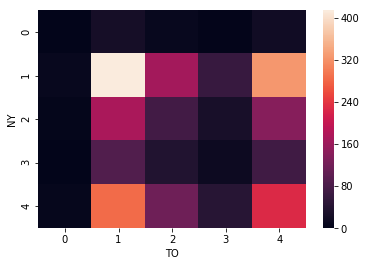

In [68]:
import seaborn as sns
%matplotlib inline
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

From above pairwise correlation, a mapping from NY to Toronto is: NY[0, [1,4] [2, 3]] to TO[0,[1,4], [2,3]]. That means we can see that if a person A interested in cluster 0 in NY, then A should to cluster 0 in Toronto. If A like cluster 4 area in Toronto, A should select cluster 1 or 4 cluster area in NY.


## Conclusion

The project has the following findings:
New York has 5 boroughs and 306 neighborhoods. Toronto has 11 boroughs and 103 neighborhoods. New York and Toronto can be divided to 5 cluster area with distinct venues differences.  New York cluster 1 and 4 is most prosperous area and both mainly located in Manhattan Toronto cluster 1 and 4 is also most prosperous area and both mainly located in financial district near the water in Toronto. Cluster 0 in both cities are the peimeter zone. Cluster 2 and 3 are local commercial areas. The detailed neighborhood in each can be found in "Neighborhood in each cluster section"